In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

from renewable_data_load import *

/Users/work/miniconda3/envs/renewables-analysis/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
def compute_standardized_index(ds_window_slice, ds_doy_slice):
    """
    Computes the standardized index for a single day-of-year slice.
    This function will be applied by xarray.apply_ufunc.

    ds_window_slice: xarray.DataArray
        The 30-day rolling window slice of historical data for ECDF fitting.
    ds_doy_slice: xarray.DataArray
        The single day-of-year data point to compute the index for.
    """
    # a. Fit ECDF to the relevant historical slice
    # Convert to a 1D numpy array for ECDF
    historical_samples = ds_window_slice.flatten()
    ecdf_func = ECDF(historical_samples)

    # b. Get the raw probability f_n(x) for the day-of-year value
    # The value to check is the single day-of-year entry
    fn_x = ecdf_func(ds_doy_slice) # fn_x is now a numpy array

    # c. Apply the ECDF smoothing/rescaling: (n * F_n(x) + 1) / (n + 2)
    # prevents the value from being exactly 0 or 1 to keep Z-scores finite
    n = len(historical_samples)
    f_x_rescaled = (n * fn_x + 1) / (n + 2)

    # d. Standardize (convert probability to Z-score)
    standardized_index = norm.ppf(f_x_rescaled)

    return standardized_index

In [3]:
resource = "pv"
module = "utility"
domain = "d03"
variable = "gen"
frequency = "day"
simulation = "all"
simulation = "ec-earth3"
scenario = "historical"
gwl = [0.8, 2.0]

ren_ds = get_ren_data_gwl(resource, module, domain, variable, frequency, simulation, gwl)

ec-earth3 0.8C: 1988-2017
ec-earth3 2.0C: 2017-2046


In [4]:
ds_reference = ren_ds[0].squeeze()
ds_future = ren_ds[1].squeeze()

In [5]:
# construct 30 day window for ECDF fitting
window_size = 30

ds_window = ds_reference.rolling(time=window_size, center=True).construct("window")
ds_window = ds_window.assign_coords({"window" : [w for w in np.arange(1,window_size+1,1)]})
#ds_window = ds_window.sel(time=slice("1982-01-01","2011-12-31"))
ds_window['dayofyear'] = ds_window.time.dt.dayofyear
ds_window['year'] = ds_window.time.dt.year
ds_window = ds_window.assign_coords(
    {"dayofyear":ds_window.time.dt.dayofyear,
    "year":ds_window.time.dt.year}
)
# reshape time dimension
ds_window = ds_window.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

# flatten each day of year to a 1d vector with all samples (30 day window x number of years)
ds_window = ds_window.stack(sample=["window","year"])
ds_window = ds_window.rename("reference_gen")
display(ds_window)

<xarray.DataArray 'reference_gen' (y: 472, x: 223, dayofyear: 366, sample: 900)> Size: 139GB
dask.array<reshape, shape=(472, 223, 366, 900), dtype=float32, chunksize=(16, 7, 88, 900), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
  * x                  (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                  (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    warming_level      float64 8B 0.8
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 421kB 30.35 30.37 30.38 ... 44.49 44.51
    lon                (y, x) float32 421kB -117.7 -117.7 ... -120.9 -120.9
  * sample             (sample) object 7kB MultiIndex
  * window             (sample) int64 7kB 1 1 1 1 1 1 1 ... 30 30 30 30 30 30 30
  * year               (sample) int64 7kB 1988 1989 1990 1991 ... 2015 2016 2017
Attributes:
    data_type:             Gridded
    extended_description:  Total power generated by installation.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             generated power
    units:                 MW

In [6]:
ds_window.load()

: 

In [7]:
ds_doy = ds_future.copy(deep=True)
ds_doy['dayofyear'] = ds_doy.time.dt.dayofyear
ds_doy['year'] = ds_doy.time.dt.year
ds_doy = ds_doy.assign_coords(
    {"dayofyear":ds_doy.time.dt.dayofyear,
    "year":ds_doy.time.dt.year}
)
# reshape time dimension
ds_doy = ds_doy.drop_vars("time").set_index(time=['dayofyear','year']).unstack()

# if sim != "ERA5":
#     # remove missing year
#     ds_doy = ds_doy.drop_sel(year=2014)
# display(ds_doy)

In [8]:
standardized_index = xr.apply_ufunc(
    compute_standardized_index,
    ds_window,
    ds_doy,
    input_core_dims=[['sample'], []], # 'sample' is the core dim for ECDF fit, none for single value check
    output_core_dims=[[]],             
    vectorize=True,                    
    dask='parallelized',              
    output_dtypes=[np.float32],        
    exclude_dims=set(('sample',))      # 'sample' dimension is consumed inside the function
)
standardized_index.name = "sei"
drought_ds = xr.merge([ds_doy,standardized_index])

/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_23195/2354134081.py:13: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  drought_ds = xr.merge([ds_doy,standardized_index])
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_23195/2354134081.py:13: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  drought_ds = xr.merge([ds_d

In [9]:
drought_ds

<xarray.Dataset> Size: 9GB
Dimensions:            (dayofyear: 366, year: 30, x: 223, y: 472)
Coordinates:
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
  * year               (year) int64 240B 2017 2018 2019 2020 ... 2044 2045 2046
  * x                  (x) float64 2kB -4.305e+06 -4.302e+06 ... -3.639e+06
  * y                  (y) float64 4kB 4.849e+05 4.879e+05 ... 1.898e+06
    warming_level      float64 8B 2.0
    Lambert_Conformal  int32 4B 1
    landmask           (y, x) float32 421kB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    lat                (y, x) float32 421kB 30.35 30.37 30.38 ... 44.49 44.51
    lon                (y, x) float32 421kB -117.7 -117.7 ... -120.9 -120.9
Data variables:
    gen                (y, x, dayofyear, year) float32 5GB dask.array<chunksize=(77, 32, 182, 30), meta=np.ndarray>
    sei                (y, x, dayofyear, year) float32 5GB dask.array<chunksize=(16, 7, 88, 30), meta=np.ndarray>
Attributes:
    data_type:             Gridded
    extended_description:  Total power generated by installation.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             generated power
    units:                 MW

In [11]:
test_ds = drought_ds.isel(x=110, y=300)

In [12]:
test_ds = test_ds.load()

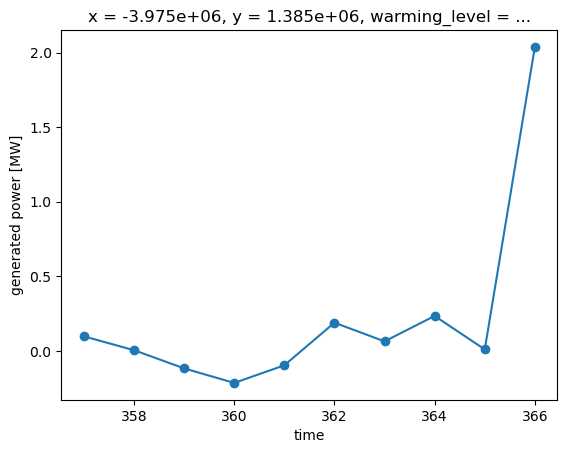

In [26]:
test_ds.mean('year').sei[-10:].plot(marker='o')

In [24]:
test_ds.mean('year').sei.values[-10:]

array([ 0.09771793,  0.00500254, -0.11692769, -0.21429141, -0.09606785,
        0.18946847,  0.06407614,  0.23476048,  0.01011854,  2.0374627 ],
      dtype=float32)

In [28]:
test_ds.mean('year').gen[-10:].values

array([324.4698 , 320.89938, 286.04184, 260.3678 , 287.2946 , 351.50787,
       321.86887, 362.79297, 298.9391 , 266.6563 ], dtype=float32)

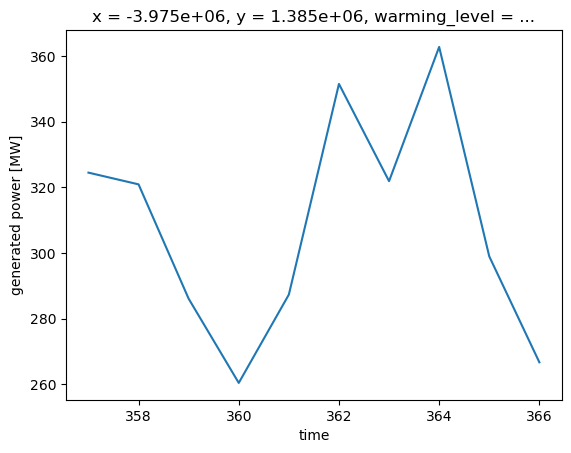

In [27]:
test_ds.mean('year').gen[-10:].plot()

In [14]:
sim = simulation
if sim != "ERA5":
    synth = np.zeros(shape=[365,1])
    synth[:,:] = np.nan
    fill_data = xr.Dataset(data_vars = {"gen" : (['dayofyear', 'year'], synth),
                                        "sei" :  (['dayofyear', 'year'], synth)},
                            coords = {"year" : (('year'), [2014]), 
                                        "dayofyear" : (('dayofyear'), np.arange(1,366,1))
                                        })
    drought_ds = xr.merge([fill_data,drought_ds])
display(drought_ds)

/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_7056/1611388786.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'year' ('year',) The recommendation is to set join explicitly for this case.
  drought_ds = xr.merge([fill_data,drought_ds])
/var/folders/1w/yd54lcgx163cw02f2gzwh9880000gp/T/ipykernel_7056/1611388786.py:10: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'dayofyear' ('dayofyear',) The recommendation is to set join explicitly for this case.
  drought_ds = xr.merge([fill_data,drought_ds])
/v

KeyboardInterrupt: 

In [18]:
drought_ds.isel(x=110, y=300)

<xarray.Dataset> Size: 91kB
Dimensions:            (dayofyear: 366, year: 30)
Coordinates:
  * dayofyear          (dayofyear) int64 3kB 1 2 3 4 5 6 ... 362 363 364 365 366
  * year               (year) int64 240B 2017 2018 2019 2020 ... 2044 2045 2046
    x                  float64 8B -3.975e+06
    y                  float64 8B 1.385e+06
    warming_level      float64 8B 2.0
    Lambert_Conformal  int32 4B 1
    landmask           float32 4B 1.0
    lat                float32 4B 38.82
    lon                float32 4B -120.5
Data variables:
    gen                (dayofyear, year) float32 44kB dask.array<chunksize=(182, 30), meta=np.ndarray>
    sei                (dayofyear, year) float32 44kB dask.array<chunksize=(88, 30), meta=np.ndarray>
Attributes:
    data_type:             Gridded
    extended_description:  Total power generated by installation.
    frequency:             day
    grid_mapping:          Lambert_Conformal
    long_name:             generated power
    units:                 MW

NameError: name 'sim' is not defined

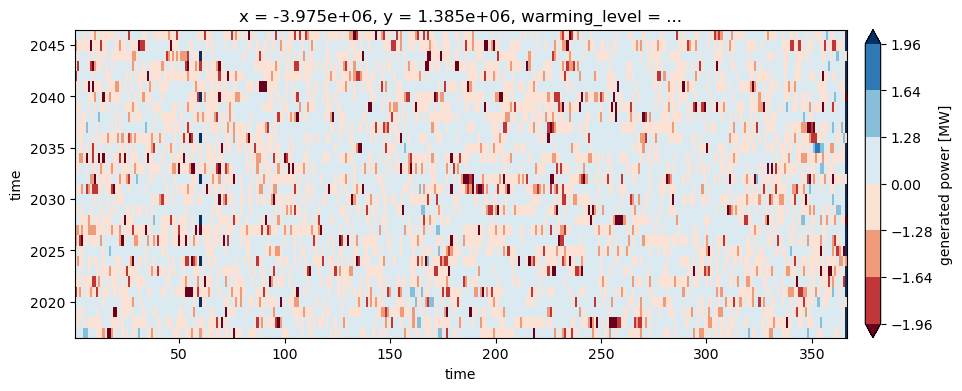

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
xr.plot.imshow(test_ds.sei.T, ax=ax, levels=[-1.96, -1.64, -1.28, 0, 1.28, 1.64, 1.96], cmap="RdBu", cbar_kwargs={'pad': 0.02})
plt.title(f"{sim} Daily {resource} SEI")
plt.ylabel("Year")
plt.xlabel("Day of Year")
plt.tight_layout()
plt.show()

In [20]:
drought_ds = drought_ds.load()
drought_ds.to_netcdf(f"../data/SEI/{resource}_{module}_{domain}_{variable}_daily_sei_{simulation}_{scenario}_gwl{gwl[0]}-{gwl[1]}.nc")

KeyboardInterrupt: 